# Finding best leakage using Bayesian optimization
First lets get some basic analogy out of the way:

In general we can shape the goal of my thesis using the following variables:

$$ Alice = X \sim \rm I\!D^1 $$

$$ Dataset = Y \sim \rm I\!D^k$$ 
such that
$$X \subset Y $$
$$1 < k \le \infty$$

Where $\rm I\!D$ is any distribution

By any given privacy preserving mechanism:

$$f: \rm I\!R^d -> \rm I\!R^n$$ 

$$Z = f(Y)$$

With all this annotation out of the way we can start to look at the goal of my thesis:

$$\underset{Y}{\operatorname{argmax}} q(X,Z)$$

where $q$ is any metric that measures the leakage in a single scalar value


### For this example:

I will:
- Maximize the leakage using BayesianOptimization `GPyOpt`
    - https://gpyopt.readthedocs.io/en/latest/
- Use Mutual Information as $q$


### Imports


In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pymc3 as pm
import numpy as np
from GPyOpt.methods import BayesianOptimization
import arviz as az
import theano
import theano.tensor as tt
import pandas as pd
import opendp.smartnoise.core as sn

### Defining f using openDP

In [23]:
@theano.compile.ops.as_op(itypes=[tt.lvector,tt.lvector,tt.lvector,
                                  tt.lvector,tt.dvector,tt.lvector,
                                  tt.lscalar],
                          otypes=[tt.dscalar])
def f(age,sex,educ,race,income,married,N):
    temp_file='temp.csv'    
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 0., # min income
                              data_upper = 200., # max income                   
                              data_rows = N
                             )
    analysis.release()
    return np.float64(age_mean.value) 

### Defining q

In [24]:
def q(X,Z):
    print(X)
    mutual_info = 0
    for x in X:
        mutual_info += mutual_info_regression(x.reshape(-1,1),Z)[0]
    return mutual_info

### What is bayesian optimization doing
It will search through each dimensions of our space of unknowns searching for the values which has the highest probability of being the maximum:

Personally I like the explanation from within here:

https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf 


### Since we are optimizing real numbers, we need to have a way of converting real numbers into distributions:


In [9]:
def map_int_to_discrete_dist(name, info, shape):
    ids, mu, std = info
    if ids == 0:
        f_a = lambda b: 2*mu-b
        b = 1/3*(mu+2*np.sqrt(3)*np.sqrt(std))
        a = f_a(b)
        if a > b:
            b,a = a,b
        elif a == b:
            b += 1
        print("uniform", a, b)
        return pm.DiscreteUniform(name, int(a), int(b), shape=shape)
    elif ids == 1:
        mu = abs(mu)
        print("posson", mu)
        return pm.Poisson(name, mu=mu, shape=shape)

In [10]:
def map_int_to_cont_dist(name, info, shape):
    ids, mu, std = info
    if ids == 0:
        ##Normal
        return pm.Normal(name, mu, std, shape=shape)
    elif ids == 1:
        #Uniform
        f_a = lambda b: 2*mu-b
        b = 1/3*(mu+2*np.sqrt(3)*np.sqrt(std))
        a = f_a(b)
        if a > b:
            b,a = a,b
        elif a == b:
            b += 1
        print("uniform", a,b)
        return pm.Uniform(name, a, b, shape=shape)
    elif ids == 2:
        #Half Normal
        print("halft", std)
        return pm.HalfNormal(name, std, shape=shape)
    elif ids == 3:
        #Gamma
        print("gamma", mu, std)
        return pm.Gamma(name, mu=abs(mu), sigma=std, shape=shape)

### Now we can construct the method which we are trying to find the maximum of

It will take a vector as input X

In [27]:
def analyse(X, samples=10_000):
    print(X)
    ids_cont = X[:,0]
    ids_disc = X[:,1:6][0]
    
    mus_cont = X[:,6]
    mus_disc = X[:,7:12][0]
    
    std_cont = X[:,12]
    std_disc = X[:,13:18][0]
    print(f"ids: {ids_cont}, ids_disc: {ids_disc}, mus_cont: {mus_cont}, mus_disc: {mus_disc}, std_cont {std_cont}, std_dist {std_disc}")
    age_information = [ids_disc[0], mus_disc[0], std_disc[0]]
    sex_information = [ids_disc[1], mus_disc[1], std_disc[1]]
    educ_information = [ids_disc[2], mus_disc[2], std_disc[2]]
    race_information = [ids_disc[3], mus_disc[3], std_disc[3]]
    income_information = [ids_cont[0], mus_cont[0], std_cont[0]]
    married_information = [ids_disc[4], mus_disc[4], std_disc[4]]
    
    with pm.Model() as model:
        N = 10
        N_rv = pm.Constant("N", N)
        
        age_dist = map_int_to_discrete_dist("age", age_information, N)
        sex_dist = map_int_to_discrete_dist("sex", sex_information, N)
        educ_dist = map_int_to_discrete_dist("educ", educ_information, N)
        race_dist = map_int_to_discrete_dist("race", race_information, N)
        income_dist = map_int_to_cont_dist("income", income_information, N)
        married_dist = map_int_to_discrete_dist("married", married_information, N)
        
        out = pm.Deterministic("out", f(age_dist, sex_dist, educ_dist, race_dist, income_dist, married_dist, N_rv))
        trace = pm.sample(samples, return_inferencedata=False, cores=1)
        
        names = ["age", "sex", "educ", "race", "income", "married"]
        alice_metric = np.asarray([trace[n][:,0] for n in names])
        
        I = q(alice_metric, trace["out"])
        return -I

### All that is done, is to construct our domain (We choose large boundaries, but they could easily be smaller)

[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  4.03314768e+02 -3.70000000e+02
  -7.49000000e+02 -7.58000000e+02 -2.93000000e+02  1.42000000e+02
   4.04769905e+03  7.81983022e+03  1.39037762e+03  4.54242250e+03
   7.33426693e+03  2.82998189e+03]]
ids: [0.], ids_disc: [0. 1. 0. 0. 1.], mus_cont: [403.31476833], mus_disc: [-370. -749. -758. -293.  142.], std_cont [4047.69905226], std_dist [7819.8302242  1390.37762425 4542.4224963  7334.26692588 2829.98188898]
uniform -718.7766088806113 -21.223391119388623
posson 749.0
uniform -1341.1572585003614 -174.84274149963863
uniform -587.2222739072917 1.222273907291651
posson 142.0


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>>Metropolis: [N]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 228 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[  -85.           -85.           -85.         ...  -192.
   -193.          -192.        ]
 [  784.           784.           784.         ...   764.
    763.           765.        ]
 [-1117.         -1090.         -1090.         ...  -785.
   -787.          -787.        ]
 [ -191.          -191.          -191.         ...  -199.
   -199.          -199.        ]
 [-6251.40460947  2088.00053655 -2071.07002572 ...  3544.16063702
   1671.12846707 -1366.76717996]
 [  150.           150.           150.         ...   146.
    145.           145.        ]]
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  7.32876634e+02 -1.43000000e+02
  -1.93000000e+02 -8.08000000e+02 -5.50000000e+02  4.29000000e+02
   7.78525106e+03  7.40019739e+03  3.43686953e+03  5.41272673e+02
   3.31604545e+03  3.28339955e+03]]
ids: [0.], ids_disc: [1. 0. 0. 0. 1.], mus_cont: [732.87663384], mus_disc: [-143. -193. -808. -550.  429.], std_cont [7785.25105685], std_dist [7

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>>Metropolis: [N]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 229 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[  153.           159.           159.         ...   156.
    155.           155.        ]
 [ -312.          -312.          -312.         ...  -231.
   -229.          -231.        ]
 [-1053.         -1052.         -1051.         ...  -876.
   -877.          -876.        ]
 [ -824.          -863.          -904.         ...  -580.
   -580.          -580.        ]
 [ 3414.56598267 -1965.05477378  3358.90519942 ...  2482.9104881
   2482.9104881  -2012.87763201]
 [  424.           419.           415.         ...   394.
    394.           395.        ]]
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -4.28370681e+02  8.51000000e+02
  -1.69000000e+02  5.29000000e+02 -4.36000000e+02  5.40000000e+02
   6.47478161e+03  3.17863936e+03  2.29917549e+03  5.01458195e+03
   7.63377357e+02  9.64481259e+03]]
ids: [0.], ids_disc: [1. 0. 0. 0. 0.], mus_cont: [-428.37068125], mus_disc: [ 851. -169.  529. -436.  540.], std_cont [6474.781608], std_dist [317

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>>Metropolis: [N]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 221 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[  844.           844.           844.         ...   837.
    836.           837.        ]
 [  -14.           -14.           -77.         ...  -167.
   -166.          -166.        ]
 [  541.           492.           492.         ...   516.
    516.           516.        ]
 [ -272.          -272.          -214.         ...  -515.
   -515.          -514.        ]
 [ 2545.1627106  -5492.20460685  4609.7671227  ... -4657.25650181
   -724.11436533 -2196.79876265]
 [  557.           557.           557.         ...   487.
    486.           486.        ]]
[[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
   1.00000000e+00  1.00000000e+00  4.54317500e+02  5.25000000e+02
  -5.88000000e+02 -4.56000000e+02 -5.03000000e+02  2.04000000e+02
   6.69739718e+03  4.90140923e+03  2.12561363e+02  6.15566296e+03
   3.83328115e+03  2.61560938e+03]]
ids: [0.], ids_disc: [1. 1. 0. 1. 1.], mus_cont: [454.3174996], mus_disc: [ 525. -588. -456. -503.  204.], std_cont [6697.39717885], std_dist [49

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>>Metropolis: [N]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 200 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[  547.           539.           552.         ...   483.
    483.           484.        ]
 [  572.           572.           572.         ...   587.
    586.           588.        ]
 [ -258.          -119.          -119.         ...  -535.
   -535.          -534.        ]
 [  497.           497.           497.         ...   479.
    479.           479.        ]
 [  839.48756561   839.48756561 -1087.01816708 ...  8073.06337259
  -2335.69393454  3334.13238204]
 [  212.           212.           203.         ...   213.
    212.           212.        ]]
[[ 3.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.30092646e+02 -2.61000000e+02
   9.96000000e+02 -5.78000000e+02 -6.50000000e+01  8.32000000e+02
   1.70927284e+03  8.86495478e+03  1.76802872e+03  5.07868563e+03
   9.09881086e+03  5.95670649e+02]]
ids: [3.], ids_disc: [1. 1. 1. 0. 0.], mus_cont: [130.09264639], mus_disc: [-261.  996. -578.  -65.  832.], std_cont [1709.27284119], std_dist [8

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>>Metropolis: [N]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 204 seconds.
There were 9015 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18303 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[[2.48000000e+02 2.48000000e+02 2.48000000e+02 ... 3.01000000e+02
  3.00000000e+02 3.01000000e+02]
 [1.00800000e+03 1.00100000e+03 1.00100000e+03 ... 9.58000000e+02
  9.57000000e+02 9.58000000e+02]
 [5.97000000e+02 5.80000000e+02 5.79000000e+02 ... 6.01000000e+02
  5.98000000e+02 5.98000000e+02]
 [4.00000000e+01 3.90000000e+01 2.90000000e+01 ... 2.20000000e+01
  2.30000000e+01 2.30000000e+01]
 [2.44071088e-22 2.44071088e-22 3.63367718e-22 ... 9.87963775e-63
  4.77207388e-57 2.71188972e-41]
 [4.57000000e+02 4.79000000e+02 4.00000000e+02 ... 9.10000000e+02
  9.10000000e+02 9.10000000e+02]]
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.82070315e+02  9.66000000e+02
   7.58000000e+02  5.92000000e+02  6.28000000e+02 -1.65000000e+02
   1.82884452e+03  2.03905476e+03  7.96248003e+03  9.03938136e+03
   1.59329027e+03  6.96580620e+03]]
ids: [0.], ids_disc: [1. 0. 0. 0. 0.], mus_cont: [-182.07031455], mus_disc: [ 966.  758.  592.  628. -165

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>>Metropolis: [N]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 203 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 992.          992.          992.         ... 1022.
  1020.         1020.        ]
 [1114.         1114.         1109.         ...  779.
   779.          780.        ]
 [ 379.          379.          379.         ...  692.
   692.          690.        ]
 [ 732.          732.          620.         ...  707.
   707.          708.        ]
 [ 497.93673544 -462.07262331 -503.32112431 ... 1938.02201583
    15.48016699 1204.62791889]
 [ -49.          -68.          -80.         ... -272.
  -272.         -273.        ]]
Value of (x,y) that minimises the objective:[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  4.03314768e+02 -3.70000000e+02
 -7.49000000e+02 -7.58000000e+02 -2.93000000e+02  1.42000000e+02
  4.04769905e+03  7.81983022e+03  1.39037762e+03  4.54242250e+03
  7.33426693e+03  2.82998189e+03]
Minimum value of the objective: -0.015138894250981139


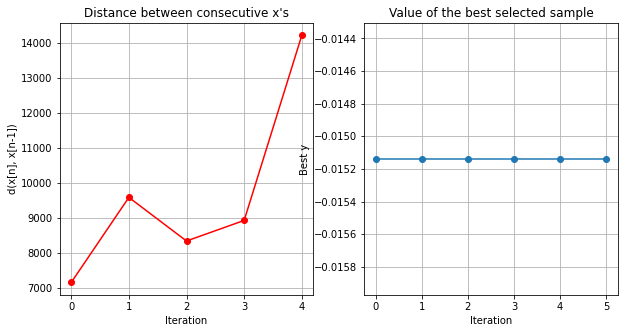

In [28]:
number_of_cont_rv = 1
number_of_disc_rv = 5

domain = [
    {"name": "ids_continuous", "type": "discrete", "domain": (0,1,2,3), "dimensionality": number_of_cont_rv},
    {"name": "ids_discrete", "type": "discrete", "domain": (0,1), "dimensionality": number_of_disc_rv},
    {"name": "mus_cont", "type": "continuous", "domain": (-1000,1000), "dimensionality": number_of_cont_rv},
    {"name": "mus_disc", "type": "discrete", "domain": tuple(range(-1000,1000)), "dimensionality": number_of_disc_rv},
    {"name": "std_cont", "type": "continuous", "domain": (1e-3, 10_000), "dimensionality": number_of_cont_rv},
    {"name": "std_disc", "type": "continuous", "domain": (1e-3, 10_000), "dimensionality": number_of_disc_rv}
]

Bopt = BayesianOptimization(f=analyse, domain=domain, 
                         initial_design_numdata = 5,   # Number data initial design
                         acquisition_type='EI',        # Expected Improvement
                         exact_feval = True)
Bopt.run_optimization(max_iter = 50, max_time=120, eps=1e-10)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

In [31]:
Bopt.plot_acquisition()

# Now we test this execution to ensure that it does in fact reach the desired value

In [9]:
res = np.asarray([Bopt.x_opt])

analyse(res, 10_000)

[[ 1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -8.35374512e+02 -4.10000000e+01
  -5.71000000e+02 -6.44000000e+02  8.35000000e+02  4.49000000e+02
   2.00345146e+03  9.17969877e+03  4.23758102e+03  6.15983251e+03
   4.34143065e+03  3.10252265e+03]]
ids: [1.], ids_disc: [0. 1. 0. 0. 0.], mus_cont: [-835.37451228], mus_disc: [ -41. -571. -644.  835.  449.], std_cont [2003.45145796], std_dist [9179.69877057 4237.58101715 6159.83251244 4341.43064986 3102.52264712]
uniform -178.96605164376166 96.96605164376167
posson 571.0
uniform -1163.9595437616017 -124.0404562383982
uniform 354.4160133584886 1315.5839866415113
uniform -1443.9751706683699 -226.77385388618615
uniform 213.9838250525313 684.0161749474687


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>>Metropolis: [N]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 175 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ -155.          -155.          -155.         ...   -60.
    -59.           -60.        ]
 [  592.           567.           567.         ...   554.
    555.           555.        ]
 [-1110.         -1110.         -1100.         ...  -676.
   -674.          -674.        ]
 [  938.           821.           631.         ...   897.
    898.           899.        ]
 [-1001.89958856  -531.44866106  -667.42886165 ...  -373.60317116
   -925.6814642  -1010.9388053 ]
 [  537.           537.           537.         ...   474.
    474.           473.        ]]


-0.020210527122417332

In [10]:
-Bopt.fx_opt

0.02390004285688274

Comparing these results we see that our test with the values reach $0.020$ where as our optimization expected to reach $0.0239$.

The reason for the difference might be due to multiple elements:
- The samples might be to low when optimizing
- Mutual information regression are not precise enough for such small value.

But in general this does show that our `f` does not leak anything, even under absurd restriction

So we found that the best attackers being as follows:
- Age:
    - uniform -178.96605164376166 96.96605164376167
- Sex:
    - poisson 571.0
- Educ: 
    - uniform -1163.9595437616017 -124.0404562383982
- Race: 
    - uniform 354.4160133584886 1315.5839866415113
- Income: 
    - uniform -1443.9751706683699 -226.77385388618615
- Married:
    - uniform 213.9838250525313 684.0161749474687

In [25]:
def analyse_part2(X, samples=10_000):
    print(X)
    ids_cont = X[:,0]
    ids_disc = X[:,1:6][0]
    
    mus_cont = X[:,6]
    mus_disc = X[:,7:12][0]
    
    std_cont = X[:,12]
    std_disc = X[:,13:18][0]
    print(f"ids: {ids_cont}, ids_disc: {ids_disc}, mus_cont: {mus_cont}, mus_disc: {mus_disc}, std_cont {std_cont}, std_dist {std_disc}")
    age_information = [ids_disc[0], mus_disc[0], std_disc[0]]
    sex_information = [ids_disc[1], mus_disc[1], std_disc[1]]
    educ_information = [ids_disc[2], mus_disc[2], std_disc[2]]
    race_information = [ids_disc[3], mus_disc[3], std_disc[3]]
    income_information = [ids_cont[0], mus_cont[0], std_cont[0]]
    married_information = [ids_disc[4], mus_disc[4], std_disc[4]]
    
    with pm.Model() as model:
        N = 10
        N_rv = pm.Constant("N", N)
        
        alice_age = pm.DiscreteUniform("alice_age",0,150,shape=1)
        age_dist = map_int_to_discrete_dist("age", age_information, N-1)
        age = tt.concatenate([alice_age,age_dist])
        
        alice_sex = pm.DiscreteUniform("alice_sex",0,2,shape=1)
        sex_dist = map_int_to_discrete_dist("sex", sex_information, N-1)
        sex = tt.concatenate([alice_sex, sex_dist])
        
        alice_educ = pm.DiscreteUniform("alice_educ",0,10,shape=1)
        educ_dist = map_int_to_discrete_dist("educ", educ_information, N-1)
        educ = tt.concatenate([alice_educ, educ_dist])
        
        alice_race = pm.DiscreteUniform("alice_race",0,50,shape=1)
        race_dist = map_int_to_discrete_dist("race", race_information, N-1)
        race = tt.concatenate([alice_race, race_dist])
        
        alice_income = pm.Normal("alice_income", mu=100,sigma=5,shape=1)
        income_dist = map_int_to_cont_dist("income", income_information, N-1)
        income = tt.concatenate([alice_income, income_dist])
        
        alice_married = pm.DiscreteUniform("alice_married",0,1,shape=1)
        married_dist = map_int_to_discrete_dist("married", married_information, N-1)
        married = tt.concatenate([alice_married, married_dist])
        
        out = pm.Deterministic("out", f(age,sex,educ,race,income,married,N_rv))
        
        trace = pm.sample(samples, return_inferencedata=False, cores=1)
        
        names = ["age", "sex", "educ", "race", "income", "married"]
        alice_metric = np.asarray([trace["alice_" + n][:,0] for n in names])
        
        I = q(alice_metric, trace["out"])
        return -I

## Runing bayesian optimization with non specific boundaries

[[ 2.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  7.00437147e+02 -4.00000000e+00
  -7.20000000e+01 -1.57000000e+02 -1.24000000e+02  6.43000000e+02
   3.80603615e+03  8.82564046e+03  6.46113599e+03  1.95457193e+03
   5.76012787e+03  4.74190358e+03]]
ids: [2.], ids_disc: [1. 1. 1. 0. 0.], mus_cont: [700.43714672], mus_disc: [  -4.  -72. -157. -124.  643.], std_cont [3806.03615469], std_dist [8825.64045845 6461.13599455 1954.5719275  5760.12786786 4741.90357921]
posson 4.0
posson 72.0
posson 157.0
uniform -294.3032485858641 46.30324858586406
halft 3806.0361546931535
uniform 293.84772263245833 992.1522773675417


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 178 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[[139.         139.         139.         ...  28.          26.
   25.        ]
 [  1.           0.           0.         ...   2.           1.
    2.        ]
 [  2.           0.           0.         ...   4.           3.
    3.        ]
 [ 10.          10.           7.         ...  37.          38.
   36.        ]
 [104.01549799  98.69356086 100.11860075 ... 113.47428097  86.49649201
  103.78146588]
 [  1.           1.           1.         ...   1.           1.
    1.        ]]
[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00 -8.92661581e+02 -2.06000000e+02
  -3.26000000e+02  9.68000000e+02 -5.85000000e+02 -5.50000000e+01
   8.09009222e+03  2.90663034e+03  3.29096502e+03  9.60533099e+02
   4.71025805e+01  3.45410027e+03]]
ids: [1.], ids_disc: [1. 0. 1. 1. 1.], mus_cont: [-892.66158067], mus_disc: [-206. -326.  968. -585.  -55.], std_cont [8090.0922234], std_dist [2906.63033772 3290.96501697  960.53309904   47.10258049 3454.10026991]
po

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 197 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 66.          94.         106.         ...  55.          56.
   54.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  1.           3.           0.         ...   3.           3.
    4.        ]
 [ 29.          29.          29.         ...  41.          40.
   41.        ]
 [ 97.9321545   91.92341525 108.06251825 ...  98.35033136  99.45801414
  102.21938938]
 [  1.           0.           0.         ...   1.           1.
    1.        ]]
[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   1.00000000e+00  0.00000000e+00  2.88317985e+02 -4.45000000e+02
  -8.17000000e+02 -8.66000000e+02  8.15000000e+02 -1.98000000e+02
   6.42934614e+03  2.90810748e+03  8.92248665e+03  6.49945566e+03
   4.76597947e+03  6.31486434e+03]]
ids: [1.], ids_disc: [1. 0. 1. 1. 0.], mus_cont: [288.31798493], mus_disc: [-445. -817. -866.  815. -198.], std_cont [6429.3461419], std_dist [2908.10748018 8922.48665427 6499.45566302 4765.97946729 6314.8643423 ]
pos

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 206 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 98.          98.          98.         ...  17.          18.
   19.        ]
 [  2.           1.           1.         ...   0.           0.
    0.        ]
 [  2.           0.           0.         ...   8.           8.
    6.        ]
 [ 26.          43.          43.         ...  15.          14.
   14.        ]
 [ 99.59234334  93.37021307 108.41838615 ...  98.06408363 103.61354878
   89.46890334]
 [  1.           0.           1.         ...   1.           1.
    1.        ]]
[[ 3.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  0.00000000e+00  1.88775870e+02  7.51000000e+02
  -9.98000000e+02 -2.76000000e+02 -9.47000000e+02 -7.94000000e+02
   9.92445776e+03  6.52302449e+03  8.87552483e+03  9.33754355e+03
   7.03297058e+03  7.84136532e+03]]
ids: [3.], ids_disc: [1. 1. 1. 1. 0.], mus_cont: [188.77586963], mus_disc: [ 751. -998. -276. -947. -794.], std_cont [9924.45775766], std_dist [6523.0244876  8875.52483362 9337.54355306 7032.97057965 7841.36532289]
po

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 296 seconds.
There were 9827 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19649 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 26.          59.         106.         ...  89.          90.
   91.        ]
 [  0.           0.           1.         ...   1.           1.
    2.        ]
 [  3.           3.           3.         ...   4.           4.
    5.        ]
 [ 11.           6.          33.         ...  48.          48.
   47.        ]
 [ 93.62698315  93.23165938  93.55828286 ... 102.56123367 108.51267044
  108.51267044]
 [  1.           1.           1.         ...   0.           0.
    0.        ]]
[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00 -6.21752418e+02  1.91000000e+02
  -6.71000000e+02  7.60000000e+01 -5.29000000e+02  6.83000000e+02
   2.68257913e+03  9.48933154e+03  1.94356548e+03  8.85948696e+03
   5.84759116e+03  4.70694188e+03]]
ids: [1.], ids_disc: [1. 0. 0. 1. 0.], mus_cont: [-621.75241794], mus_disc: [ 191. -671.   76. -529.  683.], std_cont [2682.57912856], std_dist [9489.33154368 1943.56548116 8859.48696491 5847.59115958 4706.94188478]
p

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 427 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 11.          11.          11.         ... 142.         141.
  141.        ]
 [  1.           1.           2.         ...   1.           1.
    2.        ]
 [  6.           9.           3.         ...   4.           5.
    7.        ]
 [ 32.           6.          10.         ...  36.          37.
   35.        ]
 [105.35026881 105.05667149  96.91497955 ... 104.67458157 101.07921395
  100.55747812]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[ 3.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -8.10332746e+02  5.78000000e+02
  -4.34000000e+02  1.60000000e+02  7.83000000e+02 -7.17000000e+02
   7.60127978e+03  2.05587860e+03  3.10282991e+03  4.63605875e+03
   7.37145350e+03  8.58729818e+03]]
ids: [3.], ids_disc: [1. 1. 0. 0. 0.], mus_cont: [-810.33274557], mus_disc: [ 578. -434.  160.  783. -717.], std_cont [7601.27977895], std_dist [2055.87859797 3102.82991277 4636.05874823 7371.45349506 8587.2981801 ]
p

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 415 seconds.
There were 8648 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16650 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 89.          89.          89.         ...  74.          73.
   73.        ]
 [  2.           0.           1.         ...   1.           1.
    2.        ]
 [ 10.          10.          10.         ...   7.           8.
    8.        ]
 [ 32.          19.          33.         ...  38.          39.
   41.        ]
 [ 93.61393443  92.54981502  94.87000419 ... 103.90302517 104.36547286
  104.36547286]
 [  0.           0.           0.         ...   1.           0.
    0.        ]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00 -2.60650196e+02 -6.31000000e+02
   3.36000000e+02 -6.62000000e+02  8.95000000e+02 -8.70000000e+02
   5.09488425e+03  4.93510045e+02  6.12051461e+03  4.36511262e+03
   3.80892383e+03  3.99469797e+03]]
ids: [1.], ids_disc: [0. 0. 0. 1. 0.], mus_cont: [-260.65019614], mus_disc: [-631.  336. -662.  895. -870.], std_cont [5094.88424644], std_dist [ 493.51004547 6120.51461165 4365.11262226 3808.92382901 3994.69796982]
u

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 439 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 78.           5.           4.         ...  21.          20.
   19.        ]
 [  2.           2.           0.         ...   2.           2.
    2.        ]
 [  1.           1.          10.         ...   0.           1.
    2.        ]
 [ 50.          50.          50.         ...  14.          14.
   12.        ]
 [ 98.37547819 100.06706039  96.83776873 ... 107.03607301  97.39597073
   95.10549649]
 [  1.           1.           1.         ...   0.           0.
    0.        ]]
Value of (x,y) that minimises the objective:[ 1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.35374512e+02 -4.10000000e+01
 -5.71000000e+02 -6.44000000e+02  8.35000000e+02  4.49000000e+02
  2.00345146e+03  9.17969877e+03  4.23758102e+03  6.15983251e+03
  4.34143065e+03  3.10252265e+03]
Minimum value of the objective: -0.02390004285688274


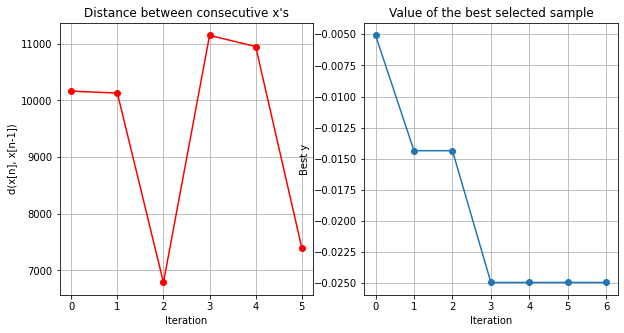

In [26]:
number_of_cont_rv = 1
number_of_disc_rv = 5

domain = [
    {"name": "ids_continuous", "type": "discrete", "domain": (0,1,2,3), "dimensionality": number_of_cont_rv},
    {"name": "ids_continuous", "type": "discrete", "domain": (0,1), "dimensionality": number_of_disc_rv},
    {"name": "mus_cont", "type": "continuous", "domain": (-1000,1000), "dimensionality": number_of_cont_rv},
    {"name": "mus_disc", "type": "discrete", "domain": tuple(range(-1000,1000)), "dimensionality": number_of_disc_rv},
    {"name": "std_cont", "type": "continuous", "domain": (1e-3, 10_000), "dimensionality": number_of_cont_rv},
    {"name": "std_disc", "type": "continuous", "domain": (1e-3, 10_000), "dimensionality": number_of_disc_rv}
]
Bopt2 = BayesianOptimization(f=analyse_part2, domain=domain, 
                         initial_design_numdata = 5,   # Number data initial design
                         acquisition_type='EI',        # Expected Improvement
                         exact_feval = True)
Bopt2.run_optimization(max_iter = 50, max_time=60*10, eps=1e-10)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt2.plot_convergence()

In [31]:
analyse_part2(np.asarray([Bopt2.x_opt]))

[[3.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  0.00000000e+00 1.00000000e+00 1.46264189e+02 8.80000000e+01
  1.00000000e+00 0.00000000e+00 1.00000000e+01 0.00000000e+00
  1.16000130e+03 1.33645586e+03 1.42739194e+03 1.91450887e+02
  1.88728445e+03 1.18499485e+02]]
ids: [3.], ids_disc: [1. 1. 1. 0. 1.], mus_cont: [146.26418913], mus_disc: [88.  1.  0. 10.  0.], std_cont [1160.00130496], std_dist [1336.45585886 1427.39194264  191.45088714 1887.28445398  118.49948505]
posson 88.0
posson 1.0
posson 0.0
uniform -33.496858647814946 53.496858647814946
gamma 146.264189134969 1160.0013049562826
posson 0.0


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 187 seconds.
There were 8470 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16079 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[[85.         85.         26.         ... 14.         14.
  15.        ]
 [ 0.          0.          1.         ...  1.          1.
   2.        ]
 [ 5.          5.          5.         ...  4.          3.
   3.        ]
 [27.          8.          8.         ...  1.          0.
   0.        ]
 [98.74495444 99.44956358 99.12998503 ... 96.79489265 99.74035226
  97.67361519]
 [ 1.          1.          0.         ...  0.          0.
   1.        ]]


-0.021217492992901654

## Analysis
Here we see that the results actually indicate that we are reaching a slightly better maximum (again hard to fully tell based on the number of executions, but still shows the point)

## Running same experiment but with our knowledge about the domains

[[3.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 4.98651506e+01 1.19000000e+02
  0.00000000e+00 9.00000000e+00 3.70000000e+01 1.00000000e+00
  7.78301236e+02 1.83820279e+03 3.74192872e+02 1.06939446e+03
  1.81374932e+03 5.65462002e+02]]
ids: [3.], ids_disc: [1. 0. 0. 0. 1.], mus_cont: [49.86515061], mus_disc: [119.   0.   9.  37.   1.], std_cont [778.30123637], std_dist [1838.20279387  374.19287159 1069.39446441 1813.74932088  565.46200182]
posson 119.0
uniform -22.33660289270638 22.33660289270638
uniform -22.760551980655677 40.76055198065568
uniform 12.490123194802855 61.509876805197145
gamma 49.86515060806909 778.3012363699879
posson 1.0


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 174 seconds.
There were 9626 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7172658311625497, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19055 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 10.          10.          51.         ...  71.          71.
   71.        ]
 [  2.           1.           1.         ...   2.           1.
    1.        ]
 [  9.           9.           1.         ...   2.           3.
    3.        ]
 [ 15.          38.          38.         ...  44.          43.
   42.        ]
 [104.16526178 102.71345812 102.98914798 ... 101.77607032  99.78567364
   99.15514669]
 [  0.           1.           1.         ...   0.           0.
    0.        ]]
[[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 1.05686747e+02 1.33000000e+02
  0.00000000e+00 8.00000000e+00 1.70000000e+01 0.00000000e+00
  6.50231245e+02 1.08796213e+03 2.25479405e+02 1.50712135e+03
  8.98844368e+01 4.56425400e+02]]
ids: [0.], ids_disc: [0. 1. 1. 0. 0.], mus_cont: [105.68674706], mus_disc: [133.   0.   8.  17.   0.], std_cont [650.23124543], std_dist [1087.9621299   225.47940502 1507.12134755   89.88443681  456.42539982]
uniform 82.4202887538711 1

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 170 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 62.          87.         101.         ... 150.         148.
  148.        ]
 [  1.           1.           0.         ...   1.           2.
    2.        ]
 [  4.           8.           8.         ...   9.          10.
   10.        ]
 [  7.           7.           7.         ...  35.          35.
   35.        ]
 [ 91.62839325  88.80397221  98.00302323 ...  93.91350346 100.97467865
  103.68270467]
 [  0.           0.           1.         ...   0.           0.
    0.        ]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 1.85419045e+02 1.33000000e+02
  0.00000000e+00 0.00000000e+00 2.60000000e+01 0.00000000e+00
  3.59935385e+02 9.63731404e+02 4.64239535e+02 1.80051822e+03
  1.88633567e+03 1.25213041e+03]]
ids: [0.], ids_disc: [0. 0. 0. 1. 0.], mus_cont: [185.41904517], mus_disc: [133.   0.   0.  26.   0.], std_cont [359.93538508], std_dist [ 963.73140394  464.23953527 1800.51821642 1886.33566632 1252.13041268]
uniform 80.17988414717817 

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 168 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 70.         135.          96.         ...  14.          14.
   14.        ]
 [  0.           0.           2.         ...   1.           1.
    1.        ]
 [  1.           1.           7.         ...   8.           8.
    9.        ]
 [ 41.          41.          43.         ...  17.          18.
   19.        ]
 [ 98.99353658  96.91220428 102.04205474 ...  99.72244344  99.26953901
  107.98218299]
 [  1.           1.           0.         ...   0.           0.
    0.        ]]
[[2.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.93825682e+02 1.05000000e+02
  1.00000000e+00 4.00000000e+00 3.00000000e+01 1.00000000e+00
  1.49293963e+03 1.07010551e+03 5.54949584e+02 7.84199029e+02
  1.64653355e+03 1.81160661e+02]]
ids: [2.], ids_disc: [0. 1. 1. 1. 1.], mus_cont: [193.82568153], mus_disc: [105.   1.   4.  30.   1.], std_cont [1492.93962588], std_dist [1070.10550566  554.94958361  784.19902887 1646.53355017  181.16066061]
uniform 72.77310340544508

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 186 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 47.         130.          38.         ... 122.         121.
  121.        ]
 [  1.           1.           1.         ...   0.           0.
    1.        ]
 [  0.           1.           1.         ...   9.          10.
   10.        ]
 [  5.           5.           5.         ...  30.          32.
   33.        ]
 [ 98.12157908  95.43665222  93.16901097 ... 106.19582665 101.14632019
   98.58069706]
 [  1.           1.           0.         ...   0.           1.
    1.        ]]
[[3.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  0.00000000e+00 1.00000000e+00 1.46264189e+02 8.80000000e+01
  1.00000000e+00 0.00000000e+00 1.00000000e+01 0.00000000e+00
  1.16000130e+03 1.33645586e+03 1.42739194e+03 1.91450887e+02
  1.88728445e+03 1.18499485e+02]]
ids: [3.], ids_disc: [1. 1. 1. 0. 1.], mus_cont: [146.26418913], mus_disc: [88.  1.  0. 10.  0.], std_cont [1160.00130496], std_dist [1336.45585886 1427.39194264  191.45088714 1887.28445398  118.49948505]
posson 88.0
posson 1.0
posson 

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 202 seconds.
There were 5602 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11822 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[[12.          5.          5.         ... 86.         85.
  85.        ]
 [ 0.          0.          1.         ...  2.          0.
   1.        ]
 [10.          7.          7.         ...  3.          4.
   4.        ]
 [ 5.         39.         35.         ... 30.         31.
  30.        ]
 [92.26937027 92.27799893 93.20408588 ... 96.95879523 95.22571181
  95.11669302]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]
[[2.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 1.13617778e+02 9.00000000e+01
  0.00000000e+00 7.00000000e+00 4.00000000e+01 0.00000000e+00
  1.70518882e+03 5.17950479e+02 1.81746445e+03 1.60217940e+02
  7.85046460e+02 4.73265765e+02]]
ids: [2.], ids_disc: [0. 1. 0. 1. 0.], mus_cont: [113.61777813], mus_disc: [90.  0.  7. 40.  0.], std_cont [1705.18881843], std_dist [ 517.95047947 1817.46444937  160.21793998  785.04645957  473.26576507]
uniform 56.27928155968955 123.72071844031045
posson 0.0
uniform -2

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 180 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[[131.         131.          31.         ...   0.           0.
    0.        ]
 [  1.           1.           0.         ...   2.           2.
    1.        ]
 [  4.           4.           4.         ...   7.           8.
    7.        ]
 [ 35.          35.          10.         ...  32.          31.
   32.        ]
 [104.00181559  99.79548143 101.45186487 ... 101.12888442 105.492028
   98.82042741]
 [  1.           1.           0.         ...   0.           0.
    0.        ]]
[[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00 1.23044673e+02 1.48000000e+02
  1.00000000e+00 8.00000000e+00 9.00000000e+00 0.00000000e+00
  1.12729305e+03 1.17529794e+03 8.50024754e+02 6.87237838e+01
  1.02714247e+03 4.55367299e+02]]
ids: [0.], ids_disc: [0. 1. 0. 1. 1.], mus_cont: [123.04467282], mus_disc: [148.   1.   8.   9.   0.], std_cont [1127.29305029], std_dist [1175.29794265  850.02475448   68.7237838  1027.14247168  455.36729858]
uniform 88.91949156481448 2

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 170 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 67.          67.          67.         ...  48.          48.
   47.        ]
 [  2.           2.           2.         ...   2.           2.
    0.        ]
 [  6.           2.           2.         ...  10.          10.
   10.        ]
 [ 20.          14.          36.         ...   6.           6.
    5.        ]
 [ 95.97550386 104.24824568  95.45995307 ... 102.70108906  92.04737385
  110.14695944]
 [  0.           0.           0.         ...   1.           1.
    0.        ]]
[[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 6.57036816e+01 6.80000000e+01
  1.00000000e+00 0.00000000e+00 3.20000000e+01 1.00000000e+00
  7.76168435e+02 7.03473316e+02 1.04874043e+03 4.38213596e+02
  8.49878296e+02 1.62978216e+03]]
ids: [0.], ids_disc: [1. 0. 0. 1. 0.], mus_cont: [65.70368162], mus_disc: [68.  1.  0. 32.  1.], std_cont [776.16843456], std_dist [ 703.47331584 1048.74042866  438.21359615  849.87829619 1629.7821643 ]
posson 68.0
uniform -35.72745815

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 172 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[139.         128.           2.         ...  67.          68.
   69.        ]
 [  1.           0.           0.         ...   0.           0.
    1.        ]
 [  6.          10.          10.         ...   8.           9.
    8.        ]
 [ 30.          30.          30.         ...  10.          11.
   10.        ]
 [101.95858208 100.53012503 101.4822818  ...  95.50480646 104.73368428
  102.37865034]
 [  1.           1.           1.         ...   1.           1.
    1.        ]]
[[1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 1.55985598e+02 1.11000000e+02
  2.00000000e+00 4.00000000e+00 4.20000000e+01 0.00000000e+00
  9.98005790e+02 1.19938051e+03 3.86777571e+02 1.91381779e+03
  1.50946460e+03 5.49552382e+02]]
ids: [1.], ids_disc: [1. 0. 1. 0. 0.], mus_cont: [155.98559769], mus_disc: [111.   2.   4.  42.   0.], std_cont [998.00579015], std_dist [1199.38051397  386.77757126 1913.81778845 1509.46460487  549.55238236]
posson 111.0
uniform -19.3

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [alice_married]
>>Metropolis: [race]
>>Metropolis: [alice_race]
>>Metropolis: [educ]
>>Metropolis: [alice_educ]
>>Metropolis: [sex]
>>Metropolis: [alice_sex]
>>Metropolis: [age]
>>Metropolis: [alice_age]
>>Metropolis: [N]
>NUTS: [income, alice_income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 174 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[[ 85.          26.         140.         ... 122.         123.
  122.        ]
 [  0.           2.           1.         ...   1.           0.
    0.        ]
 [  3.           3.           2.         ...   9.           9.
    8.        ]
 [ 22.          10.          24.         ...  38.          38.
   37.        ]
 [ 98.19780393  96.57481215 103.33596752 ...  98.20085152 101.19070767
  101.19070767]
 [  0.           0.           1.         ...   1.           1.
    1.        ]]
Value of (x,y) that minimises the objective:[ 1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.35374512e+02 -4.10000000e+01
 -5.71000000e+02 -6.44000000e+02  8.35000000e+02  4.49000000e+02
  2.00345146e+03  9.17969877e+03  4.23758102e+03  6.15983251e+03
  4.34143065e+03  3.10252265e+03]
Minimum value of the objective: -0.02390004285688274


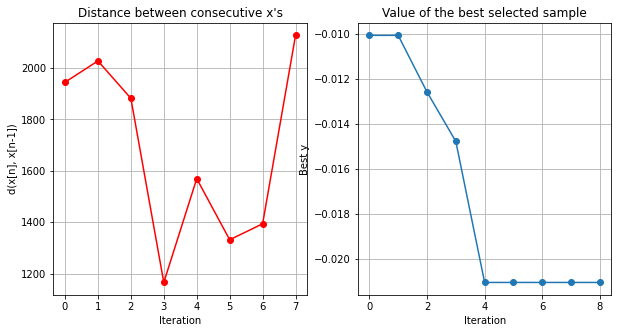

In [29]:
number_of_cont_rv = 1
number_of_disc_rv = 5

domain = [
    {"name": "ids_continuous", "type": "discrete", "domain": (0,1,2,3), "dimensionality": number_of_cont_rv},
    {"name": "ids_continuous", "type": "discrete", "domain": (0,1), "dimensionality": number_of_disc_rv},
    {"name": "mus_cont", "type": "continuous", "domain": (0,200)},
    {"name": "mus_disc", "type": "discrete", "domain": tuple(range(0,151))},
    {"name": "mus_disc", "type": "discrete", "domain": tuple(range(0,3))},
    {"name": "mus_disc", "type": "discrete", "domain": tuple(range(0,11))},
    {"name": "mus_disc", "type": "discrete", "domain": tuple(range(0,51))},
    {"name": "mus_disc", "type": "discrete", "domain": tuple(range(0,2))},
    {"name": "std_cont", "type": "continuous", "domain": (1e-3, 2000), "dimensionality": number_of_cont_rv},
    {"name": "std_disc", "type": "continuous", "domain": (1e-3, 2000), "dimensionality": number_of_disc_rv}
]
Bopt3 = BayesianOptimization(f=analyse_part2, domain=domain, 
                         initial_design_numdata = 5,   # Number data initial design
                         acquisition_type='EI',        # Expected Improvement
                         exact_feval = True)
Bopt3.run_optimization(max_iter = 50, max_time=60*10, eps=1e-10)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt3.plot_convergence()



### Analysis
Now we are limiting ourselves to realistic values, and are now suddenly getting a lower value but the results are more easily understandable

# Approach with normals
$$X \sim N(\mu_x, \sigma_x) $$
$$Y = \{Y_0, Y_1, Y_2 \}; S.t. Y_i \sim N(\mu_{y_i}, \sigma_{y_i}) $$

The database will than be the union of each element, both X and Y:
$$ Z = X \cup Y$$

The privacy preserving mechanism will be the sum of variables divided by the length.

$$ f(Z) = \dfrac{\sum_{i=0}^{4} Z_i}{4}$$

Addition of multiple i.i.d normal distribution will result in a Normal distribution where the mu and sigma are equal to the sum of its inner normal distribution. Multiplying a scalar. Meaning that the resulting distribution after the privacy preserving mechanism will be the following random variable.

$$ f(Z) \sim 4 * N(\mu_x + \mu_{y_0} + \mu_{y_1} + \mu_{y_2} + \mu_{y_3}, \sigma_x + \sigma_{y_0} + \sigma_{y_1} + \sigma_{y_2} + \sigma_{y_3}) $$

$$ f(Z) \sim N(1/4* (\mu_x + \mu_{y_0} + \mu_{y_1} + \mu_{y_2} + \mu_{y_3}), 1/(4^2) * (\sigma_x + \sigma_{y_0} + \sigma_{y_1} + \sigma_{y_2} + \sigma_{y_3})) $$


Than our metric, will be the entropy between Alice $X$ and the Output $f(Z)$. Resulting in.

$$ I(X;f(Z)) = H(f(Z)) - H(f(Z)|X) $$

Expanding this give us the following equation

$$ I(X;f(Z)) = {\displaystyle {\frac {1}{2}}\log(2\pi e(4^2 * (\sigma_x + \sigma_{y_0} + \sigma_{y_1} + \sigma_{y_2} + \sigma_{y_3})^2)} - {\displaystyle {\frac {1}{2}}\log(2\pi e(4^2 * (\sigma_{y_0} + \sigma_{y_1} + \sigma_{y_2} + \sigma_{y_3})^2)} $$

Using wolfram alpha to try and maximize it, we see that there exist no global maxima. However we can see that if all $Y$ are close to 0 than the larger $sigma_x$ will be the larger the leakage.

Since we are limiting our domain such that all $-1000 <= \mu <= 1000$ and $0.001 < \sigma_x <=1000$
The ideal values are the following:

$$Y_i = N(\mu = \text{irrelevant}, \sigma=0)$$
$$X = N(\mu = \text{irrelevant}, \sigma=1000)$$

Resulting in a mutual information of the following:
    $$arg max I(X;f(Z) $$

$$= 0.5*log(2*\pi*e*(4^2 * (1000+0.0001+0.0001+0.0001)^2)) - 0.5*log(2*\pi*e(4^2 * (0.0001+0.0001+0.0001)^2))$$

$$ \approx 17.32 $$

In [3]:
def f(x):
    return sum(x)/len(x)

In [4]:
def analyse_normal(X):
    N = 3
    mus_alice = X[:,0]
    std_alice = X[:,1]
    
    mus_rest = X[:,2]
    std_res = X[:,3]
    
    with pm.Model() as model:
        
        alice = map_int_to_cont_dist("alice", [0, mus_alice, std_alice], shape=1)
        
        rest = map_int_to_cont_dist("rest", [0, mus_rest, std_res], shape=N)
        
        db = np.empty(N+1, dtype=object)
        db[0] = alice
        for i in range(N):
            db[i+1] = rest[i]
        
        out = pm.Deterministic("out", f(db))
        
        trace = pm.sample(1_000)
        
        I = mutual_info_regression(trace["alice"].reshape((-1,1)), trace["out"], discrete_features=False)[0]
        
        return -I

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


Value of (x,y) that minimises the objective:[-564.58723651 9872.42820714  389.74554615  948.81721686]
Minimum value of the objective: -1.868855890002775


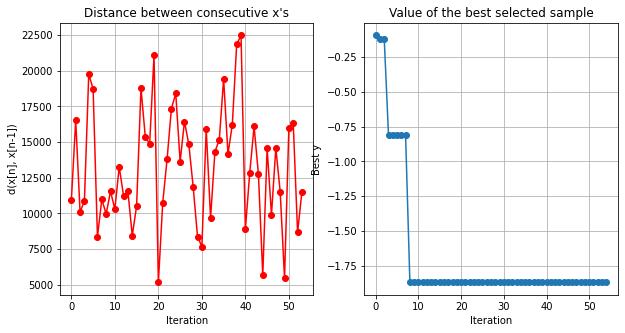

In [14]:
number_of_cont_rv = 1
number_of_disc_rv = 5

domain = [
    {"name": "alice_mu", "type": "continuous", "domain": (-1e4, 1e4)},
    {"name": "alice_std", "type": "continuous", "domain": (1e-4,1e4)},
    {"name": "rest_mu", "type": "continuous", "domain": (-1e4, 1e4)},
    {"name": "rest_std", "type": "continuous", "domain": (1e-4,1e4)}
]
Bopt = BayesianOptimization(f=analyse_normal, domain=domain, 
                         initial_design_numdata = 5,   # Number data initial design
                         acquisition_type='EI',        # Expected Improvement
                         exact_feval = True)
Bopt.run_optimization(max_iter = 50, eps=1e-10)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

Values found are:

$$\sigma_x = 9872.42$$

$$\sigma_y = 948.81721686$$

## Output from running the ideal values on the method

In [11]:
-analyse_normal(np.asarray([Bopt.x_opt]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.


2.7562445058143252

## Expected mutual information

In [13]:
-Bopt.fx_opt

2.840204889148887

# Analyse with identity

We are still using the normal. But if simply returning the normal, than the maximum leakage will be the entropy of the normal:

$$ I(X;f(Z)) = {\displaystyle {\frac {1}{2}}\log(2\pi e\sigma ^{2})} $$ 

The maximum is still unbounded, and will approach infinity as $\sigma$ grows. Therefore the maximum will be the largest value obtainable within our range.

$$arg max I(X;f(Z)) = {\displaystyle {\frac {1}{2}}\log(2\pi e* 1000^{2})} \approx 8.326 $$ 

In [11]:
def analyse_identity(X):
    N = 3
    mus_alice = X[:,0]
    std_alice = X[:,1]
    
    with pm.Model() as model:
        
        alice = map_int_to_cont_dist("alice", [0, mus_alice, std_alice], shape=1)
        
        out = pm.Deterministic("out", 1*alice)
        
        trace = pm.sample(1_000)
        
        I = mutual_info_regression(trace["alice"].reshape((-1,1)), trace["out"], discrete_features=False)[0]
        
        return -I

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8946568940189671, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8927174044154041, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8819367299945116, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.8815409068376111, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7082107137258676, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alice]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.


Value of (x,y) that minimises the objective:[1764.2722848  5654.44137416]
Minimum value of the objective: -6.327868103610282


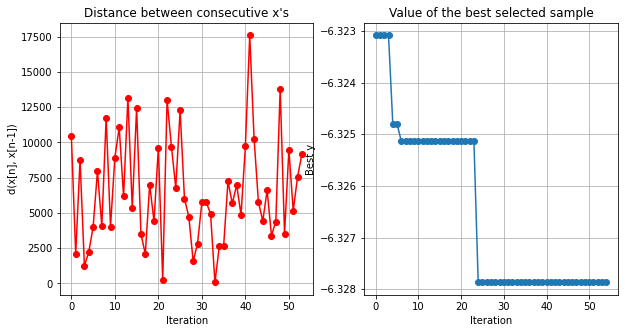

In [12]:
domain = [
    {"name": "alice_mu", "type": "continuous", "domain": (-1e4, 1e4)},
    {"name": "alice_std", "type": "continuous", "domain": (0,1e4)}
]
Bopt = BayesianOptimization(f=analyse_identity, domain=domain, 
                         acquisition_type='EI',        # Expected Improvement
                         exact_feval = True)
Bopt.run_optimization(max_iter = 50, eps=1e-10)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

# Other tests

0.9553295532955329


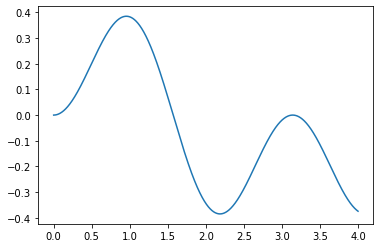

In [62]:
def formula(v):
    return np.sin(v)**2*np.cos(v)
def f(x):
    v = x[:,0][0]
    return -formula(v)

x = np.linspace(0,4,1_000_00)
plt.plot(x, [formula(xi) for xi in x])
print(x[np.argmax(formula(x))])

Value of (x,y) that minimises the objective:[0.95546231]
Minimum value of the objective: -0.3849001549506684


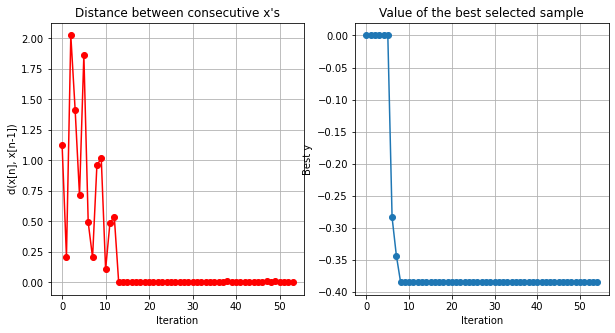

In [67]:
domain = [
    {"name": "ids_continuous", "type": "continuous", "domain": (0,4)}
]
Bopt3 = BayesianOptimization(f=f, domain=domain, 
                         initial_design_numdata = 5,   # Number data initial design
                         acquisition_type='EI',        # Expected Improvement
                         exact_feval = True)
Bopt3.run_optimization(max_iter = 50, max_time=60*10, eps=1e-10)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt3.x_opt))    
print("Minimum value of the objective: "+str(Bopt3.fx_opt))     
print("="*20)
Bopt3.plot_convergence()

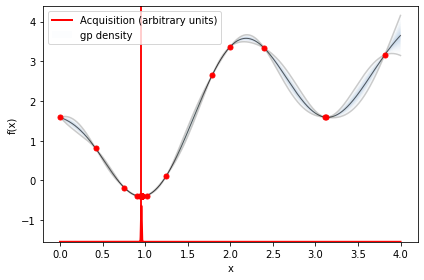

In [68]:
Bopt3.plot_acquisition()